## Intro

I'm Amit Hofree, I.D 208117341, and this is my project suggestion.

In this technological age we live in, source code is becoming more and more ubiquitous.

More and more software companies and projects are started every day, and source code is becoming more advanced, feature-filled and multi-purpose than ever before.

Source code is often classified by its "language", the collection of syntax and rules that the script must obey in order to be understood by the compiler and translated into a well defined executable.

Most of the time, a source code file's language can be inferred by its file extension. For example, C source code can be recognized by the `.c` file extension, and Python source code can be recognized by the `.py` file extension.

However, sometimes this file extension isn't available or isn't enough.

The aim of this project is to create a system for classifying source code snippets and files using only the source code content, without file extension or context, using machine learning tools.

A possible use for this system could be an advanced DLP (Data Loss Prevention) system, that monitors source code traffic in a network. Alternatively, it could be used in an IM client (Slack / Discord) to add correct syntax highlighting to a shared code snippet. More possibilities can be considered, as long as the system can detect the code in an efficient and satisfactory manner.

For demo purposes, we will try to tell apart the 3 most common programming langauges - 

1. Javscript

2. Python

3. Java


## Collecting data
As a source of data for classification, I opted to use one of the biggest (if not the biggest) sources of open-source source code - GitHub.

GitHub is a platform where anyone can store source code, display, share it, and manage its ongoing development.

As the code hosted on GitHub is publicly available, and can be acquired using a comfortable API, I aim to use it as the main source of data for training the system.

For this part, I'm planning to use PyGitHub, along with other native libraries to parse and work with the data.

In [2]:
%pip install PyGithub
%pip install scikit-plot

     |████████████████████████████████| 296kB 5.1MB/s 
     |████████████████████████████████| 962kB 8.7MB/s 


In [3]:
from github import Github
from getpass import getpass
import requests
import zipfile
import io
import glob
import random

In [7]:
def get_repos_by_language(language, token=None):
  # A GitHub PAT is used to allow a higher rate limit
  gh = Github(token)
  return gh.search_repositories(f"language:{language}")

def download_repo(repo):
  url = repo.get_archive_link("zipball")
  response = requests.get(url)
  content = response.content
  with zipfile.ZipFile(io.BytesIO(content), "r") as zf:
    zf.extractall(repo.name)
  return repo.name

LANGUAGE_TO_EXTENSION = {
    "python": "py",
    "javascript": "js",
    "java": "java"
}

def get_language_files(path, language):
  filename_list = []

  if not path.endswith("/"):
    root_dir = f"{path}/"
  else:
    root_dir = path

  pattern = f"**/*.{LANGUAGE_TO_EXTENSION[language]}"
  for filename in glob.iglob(root_dir + pattern, recursive=True):
     filename_list.append(filename)
  return filename_list

def get_random_chunks(path):
  with open(path, "r") as input_file:
    lines = input_file.readlines()
  sanitized_lines = list(map(lambda line: line.rstrip("\n"), lines))
  
  i = 0
  chunks = []
  while i < len(lines):
    if len(lines) - i == 1:
      lines_to_read = 1
    else:
      lines_to_read = random.randrange(1, len(lines) - i)
    chunks.append(sanitized_lines[i:i+lines_to_read])
    i += lines_to_read
  
  return ['\n'.join(group) for group in chunks]


In [10]:
LANGUAGES = ["python", "javascript", "java"]

def get_language_dataset(language, repo_count_per_language=10, token=None):
  samples = []
  repos_paginated = get_repos_by_language(language, token)
  chosen_repos = repos_paginated[0:repo_count_per_language]
  for repo in chosen_repos:
    try:
      downloaded_path = download_repo(repo)
      for file_path in get_language_files(downloaded_path, language):
        chunks = get_random_chunks(file_path)
        samples += chunks
    except:
      pass
  
  return samples, [language] * len(samples)

We query GitHub using the Search API to find repositories containing files of the correct programming language. Then, we download the repository and filter it for files with the correct file extension for the programming language.

Finally, we split each of these files to random sized chunks

In [14]:
examples = get_language_dataset('javascript', repo_count_per_language=1)
example = examples[0]

In [23]:
# Printing some example chunks
for i in range(5):
  print(f"i={i}:")
  print(example[i])
  print()

i=0:
const babelOptions = {
  presets: [
    [
      '@babel/preset-env',
      {
        targets: {

i=1:
          node: 14
        }

i=2:
      }
    ],
    '@babel/react'
  ]
};


i=3:
module.exports = require('babel-jest').createTransformer(babelOptions);

i=4:
const util = require('cypress/lib/util');
const execa = require('execa');




For these demo purposes, I'm build a dataset containing 100 repositories from each programming language.

In [33]:
def build_dataset(repo_count_per_language=100):
  samples = []
  labels = []

  token = getpass("Enter a GitHub PAT: ")
  for language in LANGUAGES:
    lang_samples, lang_labels = get_language_dataset(language, repo_count_per_language, token)
    samples += lang_samples
    labels += lang_labels
  
  return samples, labels

In [34]:
dataset = build_dataset()

Enter a GitHub PAT: ··········


### Storing dataset
To avoid having to recalculate the database in each run, we store the dataset in a pickle file, which is in turn stored in Google Drive.

In subsequent steps of the classification, we will pull the dataset from this file.

In [35]:
import bz2
import pickle
from google.colab import drive

In [36]:
drive.mount("/content/drive")
with bz2.BZ2File("/content/drive/My Drive/project_dataset.pbz2", 'w') as pkl_file: 
    pickle.dump(dataset, pkl_file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Classifying snippets
As an initial approach, I have attempted to use bag of words to classify the different snippets.

In the BoW technique, we will take all the words in every sample, then count the number of occurrences of each word in each sample, generating a fixed-length vector to describe each one of the samples.

This sample in turn will be fed into a linear classifier, in our case a Naive Bayes classifier.

In [37]:
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [38]:
import bz2
import pickle
from google.colab import drive

def load_dataset():
  drive.mount("/content/drive")
  with bz2.BZ2File("/content/drive/My Drive/project_dataset.pbz2", 'r') as pkl_file: 
    dataset = pickle.load(pkl_file)
  return dataset

In [39]:
try:
  dataset
except NameError:
  dataset = load_dataset()

samples, labels = dataset
samples_train, samples_test, labels_train, labels_test = train_test_split(samples, labels)

In [40]:
vectorizer = CountVectorizer(lowercase=False, max_features=1000)
samples_bow_train = vectorizer.fit_transform(samples_train)

In [41]:
classifier = MultinomialNB()
classifier.fit(samples_bow_train, labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [42]:
samples_bow_test = vectorizer.transform(samples_test)

In [43]:
labels_test_predict = classifier.predict(samples_bow_test)

In [44]:
accuracy_score(labels_test, labels_test_predict)

0.8730154583819492

In [45]:
labels_test_proba = classifier.predict_proba(samples_bow_test)

In [46]:
y_true = np.array(labels_test)
y_probas = labels_test_proba

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


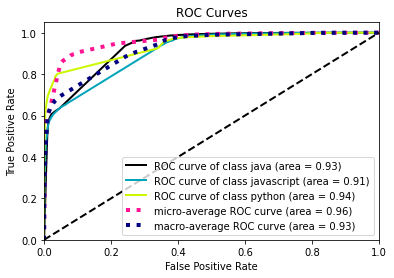

In [47]:
import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_true, y_probas)

## Goals
In continuing this project, I hope to achieve the following goals - 

1. Classifying between the top 100 most popular programming languages
2. Classification accuracy should be higher than 95% on average
3. Classifying a single sample should happen instantly. This is to support network appliances of the classifier
4. Adding a new progamming language to the model should be trivial, aside from time and cost of retraining the model.

In order to achieve these goals, I plan to create a more robust and thorough engine of collecting source code from Github, using more resources and a multithreaded approach. This will be done to allow gathering of a great number of samples, across more programming languages.

Furthermore, I will explore various classifying techniques in order to improve the speed and accuracy of the models. These techniques will range from naive classification methods to more specialized approaches that leverage domain-specific knowledge about the samples.

